# ENEN 645 — Assignment 2: Multimodal Garbage Classification (Evaluation Notebook)

## Team Members:
 - Shedrack Chibueze Ogbuike
 - Saad Abedrabuh
 
This notebook satisfies the rubric requirement to include a **Jupyter Notebook** that contains:
- **Predictions** of the model
- **Metrics** (accuracy + classification report)
- **Figures** (confusion matrix)
- **Figures of incorrect classifications** (misclassified examples)

Training was performed using the script in `src/train_multimodal.py` (ResNet50 + filename-text Bag-of-Words fusion).
Evaluation artifacts are loaded from the `results/` folder.


In [37]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from PIL import Image

In [43]:
start = Path.cwd().resolve()
for p in [start] + list(start.parents):
    if (p / "results").exists() and (p / "src").exists():
        REPO_ROOT = p
        break
else:
    REPO_ROOT = start  

RESULTS_DIR = REPO_ROOT / "results"

PRED_CSV = RESULTS_DIR / "test_predictions.csv"
CM_PNG   = RESULTS_DIR / "confusion_matrix.png"
MIS_PNG  = RESULTS_DIR / "misclassified_examples.png"
LOSS_PNG = RESULTS_DIR / "loss_curve.png"
ACC_PNG  = RESULTS_DIR / "acc_curve.png"


In [48]:
# Load predictions
preds = pd.read_csv(PRED_CSV)
print("Rows:", len(preds))
print("Columns:", list(preds.columns))
preds.head()


Rows: 3432
Columns: ['path', 'text', 'true', 'pred']


,path,text,true,pred
0,/work/TALC/ensf617_2026w/garbage_data/CVPR_202...,yogurt container seal,Black,Black
1,/work/TALC/ensf617_2026w/garbage_data/CVPR_202...,kerig coffee pod,Black,Black
2,/work/TALC/ensf617_2026w/garbage_data/CVPR_202...,unusable pencil,Black,Black
3,/work/TALC/ensf617_2026w/garbage_data/CVPR_202...,disposable plastic fork onetime use,Black,Black
4,/work/TALC/ensf617_2026w/garbage_data/CVPR_202...,waste tape,Black,Black


In [44]:
cols = {c.lower(): c for c in preds.columns}

def pick(*names):
    for n in names:
        if n in cols:
            return cols[n]
    return None

TRUE_COL = pick("true", "true_label", "label", "y_true")
PRED_COL = pick("pred", "pred_label", "prediction", "y_pred")

if TRUE_COL is None or PRED_COL is None:
    raise ValueError(f"Could not detect true/pred columns. Found columns: {list(preds.columns)}")

print("Using columns -> TRUE:", TRUE_COL, "| PRED:", PRED_COL)


Using columns -> TRUE: true | PRED: pred


In [51]:
# Overall accuracy
acc = (preds[TRUE_COL] == preds[PRED_COL]).mean() * 100
print(f"Test Accuracy: {acc:.2f}%")

Test Accuracy: 83.77%


In [52]:
labels = sorted(pd.unique(preds[TRUE_COL]))
print("Labels:", labels)

Labels: ['Black', 'Blue', 'Green', 'TTR']


In [53]:
# Classification report
print("Classification Report:\n")
print(classification_report(preds[TRUE_COL], preds[PRED_COL], labels=labels))


Classification Report:

              precision    recall  f1-score   support

       Black       0.78      0.68      0.73       695
        Blue       0.79      0.90      0.84      1086
       Green       0.92      0.91      0.91       799
         TTR       0.87      0.82      0.84       852

    accuracy                           0.84      3432
   macro avg       0.84      0.83      0.83      3432
weighted avg       0.84      0.84      0.84      3432



## Confusion Matrix
This figure summarizes class-level performance and common misclassification patterns.

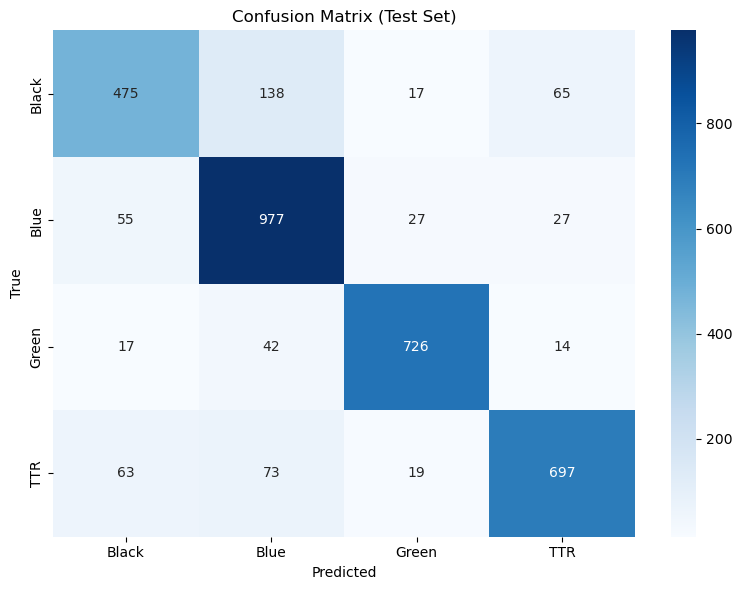

In [31]:
cm = confusion_matrix(preds[TRUE_COL], preds[PRED_COL], labels=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Test Set)")
plt.tight_layout()
plt.show()


In [32]:
per_class_acc = (cm.diagonal() / cm.sum(axis=1)) * 100
for name, a in zip(labels, per_class_acc):
    print(f"Accuracy for {name}: {a:.2f}%")


Accuracy for Black: 68.35%
Accuracy for Blue: 89.96%
Accuracy for Green: 90.86%
Accuracy for TTR: 81.81%


## Incorrect Classifications
Examples below illustrate typical failure cases of the model.

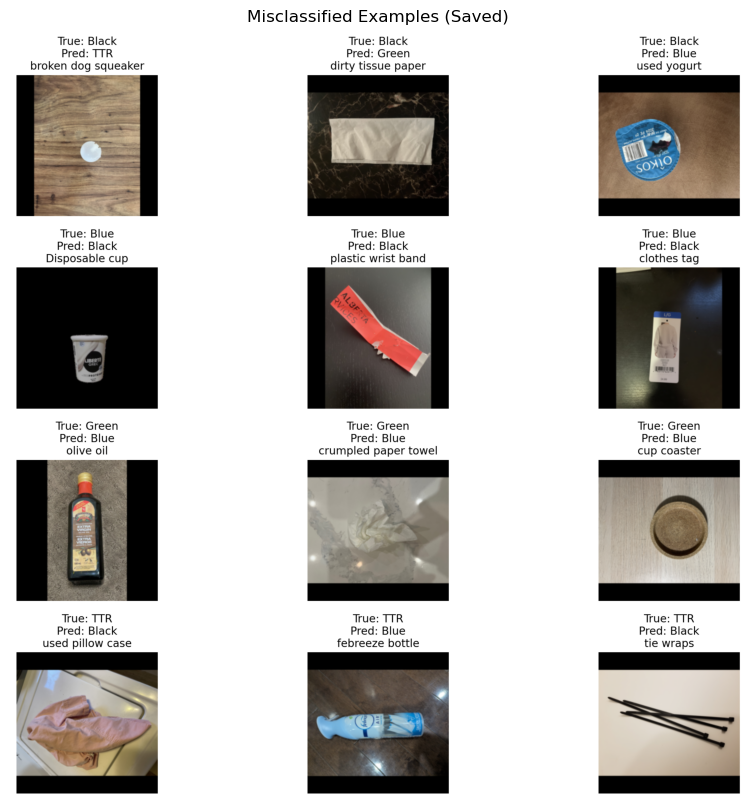

In [33]:
if MIS_PNG.exists():
    img = Image.open(MIS_PNG)
    plt.figure(figsize=(14, 10))
    plt.imshow(img)
    plt.axis("off")
    plt.title("Misclassified Examples (Saved)")
    plt.show()
else:
    print("misclassified_examples.png not found in results/.")


In [45]:
mis = preds[preds[TRUE_COL] != preds[PRED_COL]]

mis_per_class = (
    mis.groupby(TRUE_COL)
       .size()
       .rename("misclassified_count")
       .reset_index()
)

mis_per_class


,true,misclassified_count
0,Black,220
1,Blue,109
2,Green,73
3,TTR,155


In [ ]:
mis = preds[preds[TRUE_COL] != preds[PRED_COL]].copy()
print("Total misclassified:", len(mis))

mis.head(15)


Total misclassified: 557


,path,text,true,pred
5,/work/TALC/ensf617_2026w/garbage_data/CVPR_202...,wire scourer,Black,TTR
10,/work/TALC/ensf617_2026w/garbage_data/CVPR_202...,empty toothpaste tubes,Black,Blue
11,/work/TALC/ensf617_2026w/garbage_data/CVPR_202...,plastic and metal contact case,Black,Blue
13,/work/TALC/ensf617_2026w/garbage_data/CVPR_202...,dried gluestick,Black,TTR
14,/work/TALC/ensf617_2026w/garbage_data/CVPR_202...,led bulb,Black,TTR
19,/work/TALC/ensf617_2026w/garbage_data/CVPR_202...,expired jam,Black,Blue
21,/work/TALC/ensf617_2026w/garbage_data/CVPR_202...,used yogurt,Black,Blue
23,/work/TALC/ensf617_2026w/garbage_data/CVPR_202...,Plastic Bag,Black,Blue
27,/work/TALC/ensf617_2026w/garbage_data/CVPR_202...,old lighter,Black,TTR
30,/work/TALC/ensf617_2026w/garbage_data/CVPR_202...,key,Black,TTR


In [46]:
total_per_class = preds.groupby(TRUE_COL).size()

mis_stats = mis_per_class.copy()
mis_stats["total_samples"] = mis_stats[TRUE_COL].map(total_per_class)
mis_stats["misclassification_rate_%"] = (
    mis_stats["misclassified_count"] / mis_stats["total_samples"] * 100
)

mis_stats


,true,misclassified_count,total_samples,misclassification_rate_%
0,Black,220,695,31.654676
1,Blue,109,1086,10.036832
2,Green,73,799,9.136421
3,TTR,155,852,18.192488


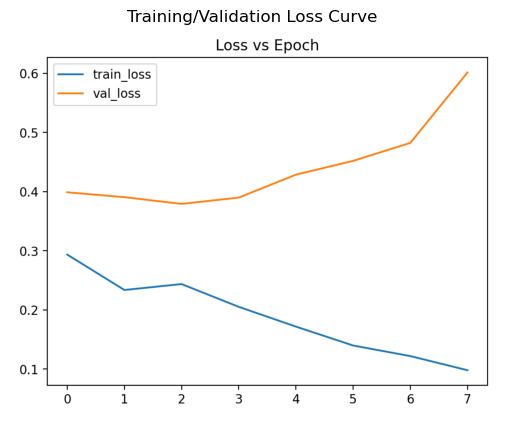

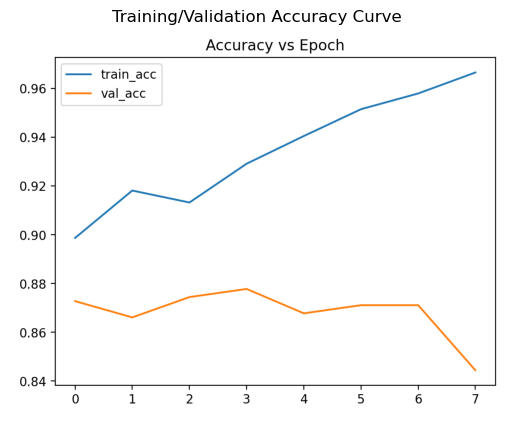

In [35]:
def show_png(path, title):
    if path.exists():
        img = Image.open(path)
        plt.figure(figsize=(10, 5))
        plt.imshow(img)
        plt.axis("off")
        plt.title(title)
        plt.show()
    else:
        print("Missing:", path.name)

show_png(LOSS_PNG, "Training/Validation Loss Curve")
show_png(ACC_PNG,  "Training/Validation Accuracy Curve")


## Discussion (Summary)

- The multimodal model combines **ResNet50 image features** with **filename-derived Bag-of-Words text features**.
- Performance is reported using accuracy, confusion matrix, and per-class metrics.
- Misclassified examples highlight common failure cases (e.g., visually similar bins or ambiguous lighting/background).
- This notebook provides the rubric-required **predictions, metrics, and incorrect classification figures**.
